<a href="https://colab.research.google.com/github/shivRVS/classifyImg/blob/main/WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Classification

Project: Weather Image Classifer

In [35]:
COLAB = True

In [10]:
#unziping image files
!unzip dataset.zip

Archive:  dataset2.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/cloudy/
  inflating: dataset/test/cloudy/cloudy01.jpg  
  inflating: dataset/test/cloudy/cloudy02.jpg  
  inflating: dataset/test/cloudy/cloudy03.jpg  
  inflating: dataset/test/cloudy/cloudy04.jpg  
  inflating: dataset/test/cloudy/cloudy05.jpg  
  inflating: dataset/test/cloudy/cloudy06.jpg  
  inflating: dataset/test/cloudy/cloudy07.jpg  
  inflating: dataset/test/cloudy/cloudy08.jpg  
  inflating: dataset/test/cloudy/cloudy09.jpg  
  inflating: dataset/test/cloudy/cloudy10.jpg  
  inflating: dataset/test/cloudy/cloudy11.jpg  
  inflating: dataset/test/cloudy/cloudy12.jpg  
  inflating: dataset/test/cloudy/cloudy13.jpg  
   creating: dataset/test/fogsmog/
  inflating: dataset/test/fogsmog/fogsmog001.jpg  
  inflating: dataset/test/fogsmog/fogsmog002.jpg  
  inflating: dataset/test/fogsmog/fogsmog003.jpg  
  inflating: dataset/test/fogsmog/fogsmog004.jpg  
  inflating: dataset/test/fogsm

In [38]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import model_to_dot


from IPython.display import SVG
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2830182173169388712
 xla_global_id: -1]

## 02 - Data Exploration Analysis (EDA)

In this section we will proceed to perform the exploration and analysis of the data.

First, we will proceed to review the structure of the dataset and show some examples of images.


In [39]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0
PATH = 'dataset'

for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  dataset
Searching in :  dataset\test
Searching in :  dataset\test\cloudy
Searching in :  dataset\test\rain
Searching in :  dataset\test\shine
Searching in :  dataset\test\sunrise
Searching in :  dataset\training
Searching in :  dataset\training\cloudy
Searching in :  dataset\training\rain
Searching in :  dataset\training\shine
Searching in :  dataset\training\sunrise
Searching in :  dataset\validation
Searching in :  dataset\validation\cloudy
Searching in :  dataset\validation\rain
Searching in :  dataset\validation\shine
Searching in :  dataset\validation\sunrise
Total number of files 1128
Total Number of directories 15
Total: 1143


The dataset is composed of images for training, validation and test. The test samples will be used for the final evaluation of the model.

Each subfolder in turn is made up of weather type samples such as: cloudy, shine, sunrise, rain, which are the targets for our ML model.

We have 1125 images samples, and now we will dataset distribution



In [42]:
#Count images samples for each category.

targets = ['cloudy','rain','shine','sunrise']

def count_targets(path_dataset, targets = targets):
  """
  Function to count samples for each category
  input: 
    path_to_dataset - (example, validation, training or test)
    targets - targets from dataset for each category
  output:
    count_target - numpy array with count files for each category
  
  """
  counts_target = []
  for folder in targets:
    path, dirs, files = next(os.walk(path_dataset+folder))
    file_count = len(files)    
    counts_target.append([folder,file_count])
    
  return np.array(counts_target, dtype = object)

train_samples = count_targets(path_dataset = 'dataset/training/')
validation_samples = count_targets(path_dataset = 'dataset/validation/')
test_samples = count_targets(path_dataset = 'dataset/test/')


Text(0.5, 1.0, 'Training Samples')

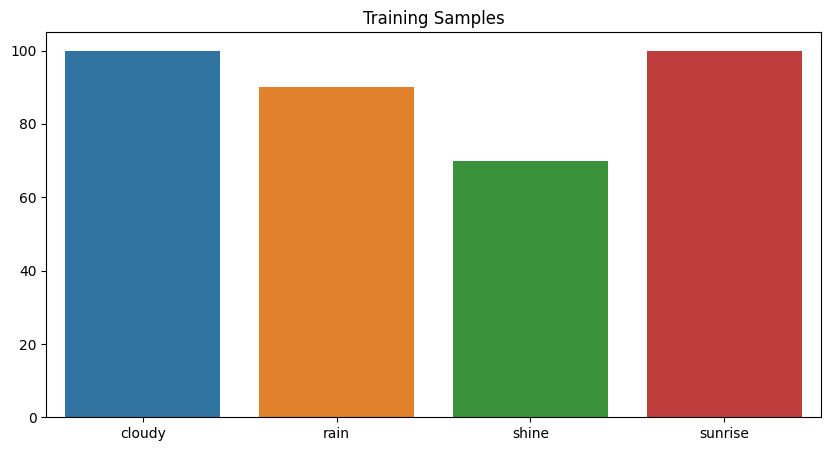

In [43]:
#Let's plot samples distribution for training
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = train_samples[:,1])
ax.set_title("Training Samples")

Text(0.5, 1.0, 'Validation Samples')

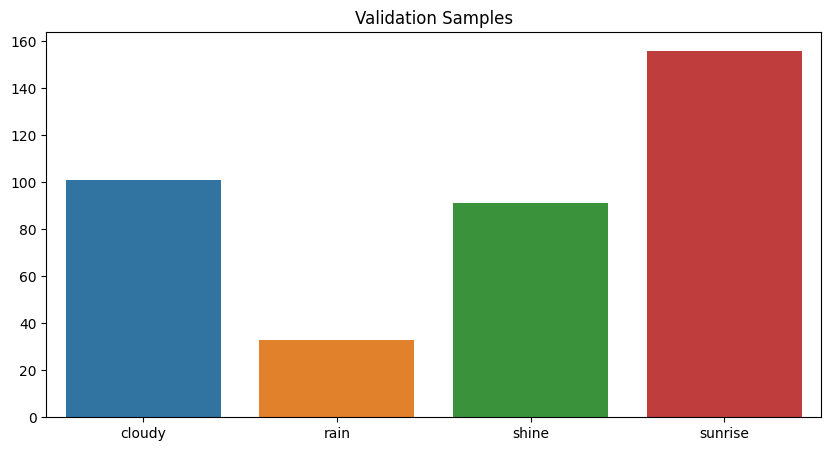

In [44]:
#Let's plot samples distribution for validation
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = validation_samples[:,1])
ax.set_title("Validation Samples")

Text(0.5, 1.0, 'Test Samples')

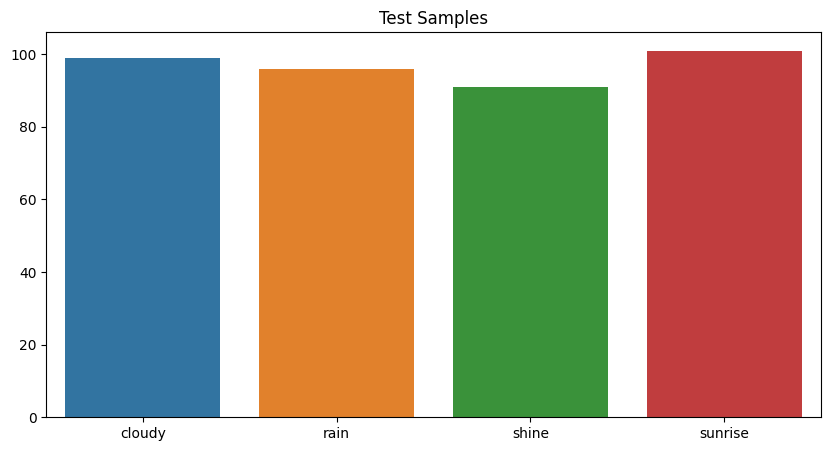

In [45]:
#Let's plot samples distribution for testing
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = test_samples[:,0], y = test_samples[:,1])
ax.set_title("Test Samples")

### Images samples

Now we will proceed to show some training samples of the images to see some features


(224, 224)


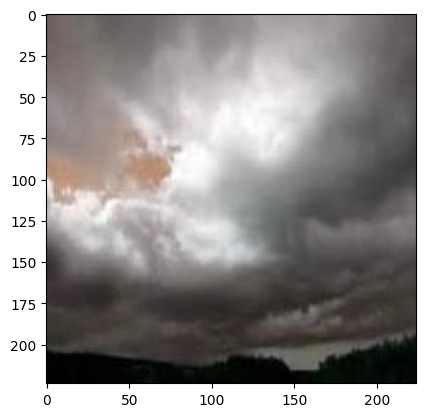

In [46]:
#cloudy
img = Image.open("dataset/training/cloudy/cloud_107.jpeg")
print(img.size)
plt.imshow(img)

(224, 224)


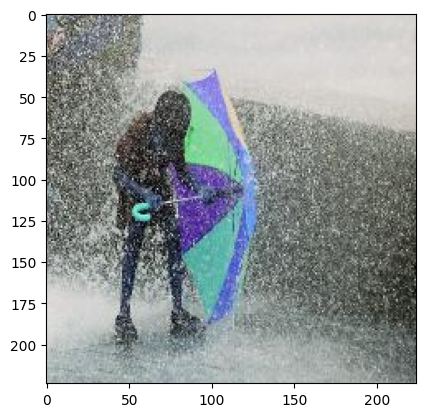

In [47]:
#rain
img = Image.open("dataset/training/rain/rain_91.jpeg")
print(img.size)
plt.imshow(img)

(224, 224)


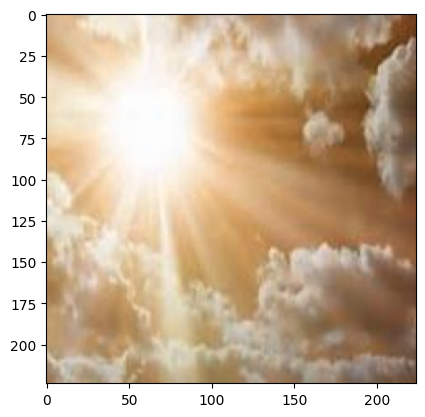

In [48]:
#shine
img = Image.open("dataset/training/shine/shine_97.jpeg")
print(img.size)
plt.imshow(img)

(224, 224)


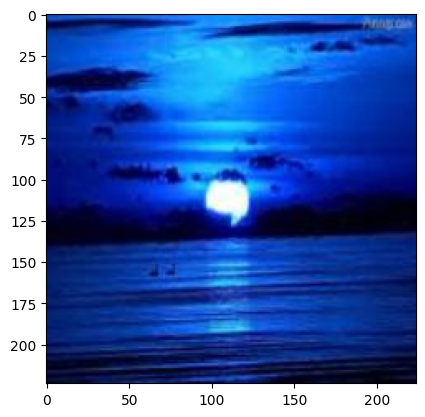

In [27]:
#sunrise
img = Image.open("dataset/validation/sunrise/sunrise_225.jpeg")
print(img.size)
plt.imshow(img)

## 03 - Image Processing anda Data Augmentation

At this stage we are going to generate images using Keras Generator and then save it in a temporary directory "preview/", in this way we can see how the Data Augmentation strategy is working. We disable rescaling so that images can be easily viewed.

In [49]:
!mkdir preview/
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dataset/training/rain/rain_99.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

The syntax of the command is incorrect.


Now it's time to load the dataset with the image generator from Keras. We will use the following configurations: rescaling, rotation, shear range, zoom and horizontal flip.

In [50]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

# this is the augmentation configuration we will use just for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only for rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/training/',  # this is the target directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for test data
test_generator = validation_datagen.flow_from_directory(
        'dataset/test/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 360 images belonging to 4 classes.
Found 381 images belonging to 4 classes.


Found 387 images belonging to 4 classes.


As shown above, the generators are effectively loaded with the number of samples and categories (targets) identified.

## 04 - Model Implementation

We are now ready to define our model. The strategy for this work is to make two models from scratch and one using transfer learning, in this way we can see the behavior and performance of each one.

### Model 1 Architecture

The one-block model has two single convolutional layer with 32, 16 filters followed by a max pooling layer.

In [53]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers - Block1
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)

classifier = keras.layers.Dense(4, activation="softmax")(dropout)

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 200)               18000200  
                                                             

In [51]:
#display model
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

ImportError: You must install pydot (`pip install pydot`) for model_to_dot to work.

Visual Simple Model Architecture

     |████████████████████████████████| 795 kB 12.4 MB/s 


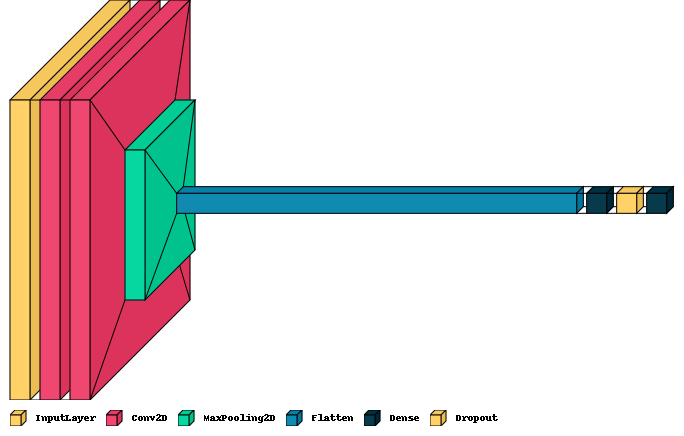

In [27]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True,scale_xy=2)

### Model 2 Architecture
The two-block model has two convolutional blocks, each block followed by a max pooling layer.

In [54]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(4, activation="softmax")(dropout)

model2 = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

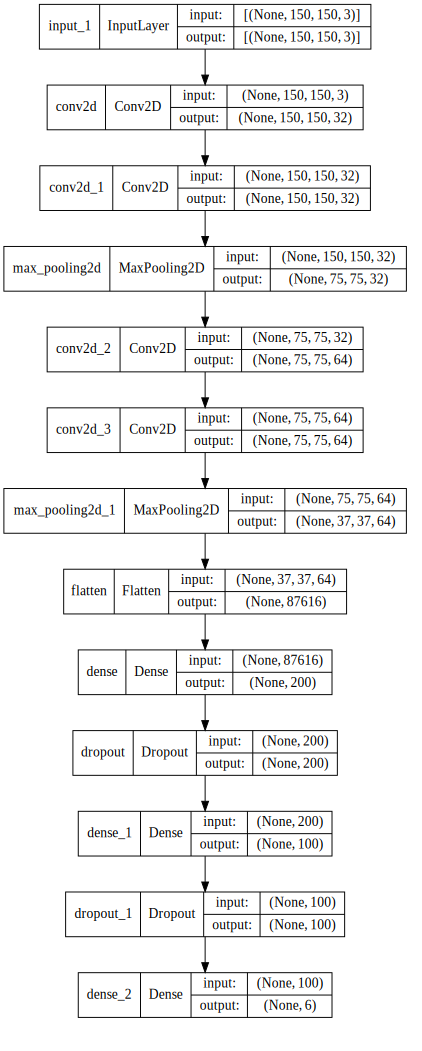

In [29]:
if COLAB:
    display(SVG(model_to_dot(model2, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg')))

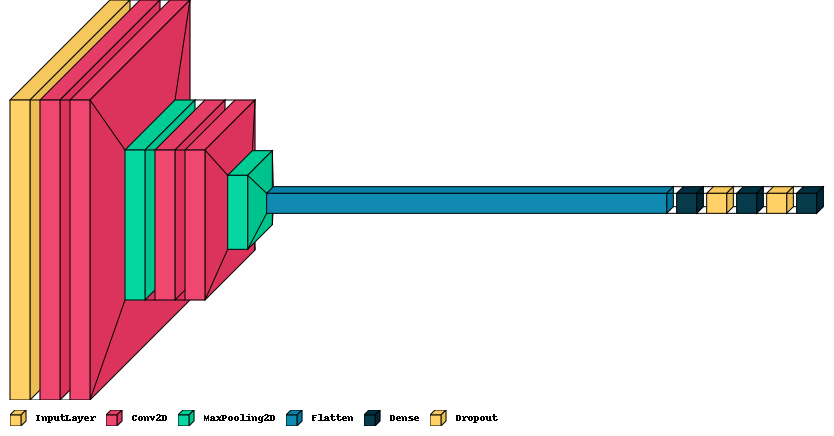

In [30]:
visualkeras.layered_view(model2).show() # display using your system viewer
visualkeras.layered_view(model2, legend=True,scale_xy=2)

## 05 - Training Model

Our two models from scratch are already prepared for Training, we will proced with 50 epochs for each one.

### Training Model 1

In [55]:
history1 = model.fit(train_generator,validation_data=validation_generator, epochs=10)

Epoch 1/10
12/12 [==============================] - 15s 1s/step - loss: 3.4190 - accuracy: 0.4694 - val_loss: 0.9517 - val_accuracy: 0.5381
Epoch 2/10
12/12 [==============================] - 13s 1s/step - loss: 0.7377 - accuracy: 0.6833 - val_loss: 0.7323 - val_accuracy: 0.7297
Epoch 3/10
12/12 [==============================] - 12s 1s/step - loss: 0.6216 - accuracy: 0.7778 - val_loss: 0.7576 - val_accuracy: 0.7533
Epoch 4/10
12/12 [==============================] - 13s 1s/step - loss: 0.5387 - accuracy: 0.8000 - val_loss: 0.7163 - val_accuracy: 0.7874
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 0.5207 - accuracy: 0.8000 - val_loss: 0.7031 - val_accuracy: 0.7638
Epoch 6/10
12/12 [==============================] - 13s 1s/step - loss: 0.4818 - accuracy: 0.8194 - val_loss: 0.5970 - val_accuracy: 0.7927
Epoch 7/10
12/12 [==============================] - 14s 1s/step - loss: 0.4331 - accuracy: 0.8583 - val_loss: 0.8350 - val_accuracy: 0.7769
Epoch 8/10
12/12 [==

### Training Model 2

In [56]:
history2 = model2.fit(train_generator,validation_data=validation_generator, epochs=10)

Epoch 1/10
12/12 [==============================] - 23s 2s/step - loss: 1.1354 - accuracy: 0.4667 - val_loss: 0.7468 - val_accuracy: 0.6562
Epoch 2/10
12/12 [==============================] - 22s 2s/step - loss: 0.8131 - accuracy: 0.5833 - val_loss: 0.7194 - val_accuracy: 0.6824
Epoch 3/10
12/12 [==============================] - 24s 2s/step - loss: 0.8366 - accuracy: 0.6083 - val_loss: 0.7447 - val_accuracy: 0.7638
Epoch 4/10
12/12 [==============================] - 22s 2s/step - loss: 0.7039 - accuracy: 0.6750 - val_loss: 0.6585 - val_accuracy: 0.7822
Epoch 5/10
12/12 [==============================] - 22s 2s/step - loss: 0.5993 - accuracy: 0.7528 - val_loss: 0.6849 - val_accuracy: 0.7375
Epoch 6/10
12/12 [==============================] - 23s 2s/step - loss: 0.4921 - accuracy: 0.7778 - val_loss: 0.6236 - val_accuracy: 0.7743
Epoch 7/10
12/12 [==============================] - 22s 2s/step - loss: 0.6055 - accuracy: 0.7444 - val_loss: 0.7378 - val_accuracy: 0.7795
Epoch 8/10
12/12 [==

## 06 - Loss and Accuracy Plotting

In [57]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

### Plotting Model Performance 1

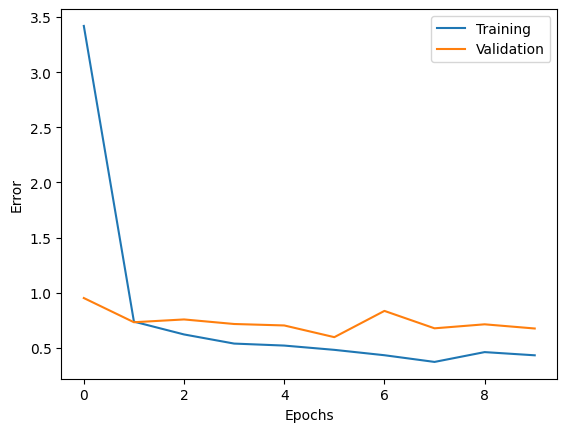

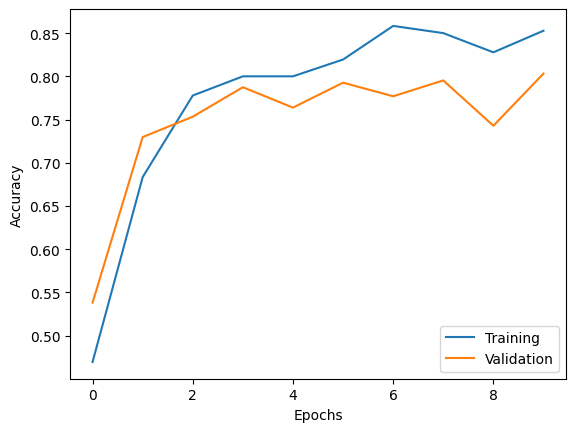

In [58]:
plot_curves(history1.history)

### Plotting Model Performance 2

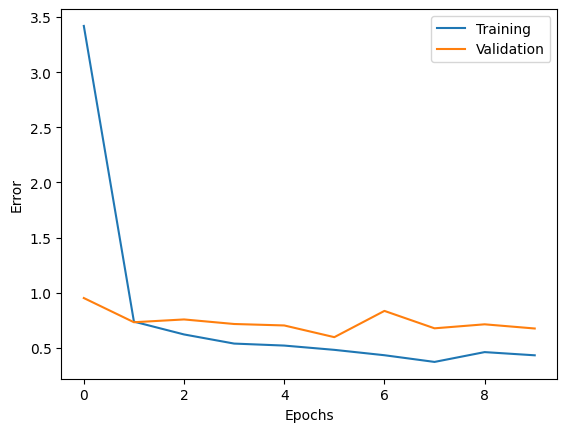

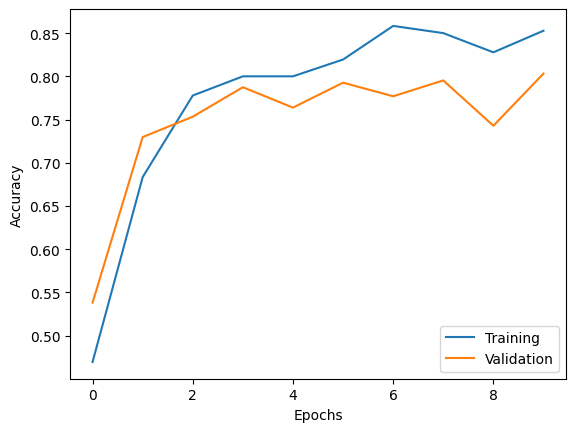

In [59]:
plot_curves(history1.history)

## 07 - Preliminar Scores (Training & Validation)

### Scores Model 1

In [60]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

12/12 [==============================] - 3s 263ms/step - loss: 0.3238 - accuracy: 0.8917
Train loss    : 0.32381707429885864
Train accuracy: 0.8916666507720947
12/12 [==============================] - 2s 159ms/step - loss: 0.6755 - accuracy: 0.8031
Val loss    : 0.6754536628723145
Val accuracy: 0.8031495809555054
13/13 [==============================] - 2s 175ms/step - loss: 0.5876 - accuracy: 0.8527
Test loss    : 0.5875585079193115
Test accuracy: 0.8527131676673889


### Scores Model 2

In [61]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

12/12 [==============================] - 4s 342ms/step - loss: 0.3932 - accuracy: 0.8500
Train loss    : 0.3932480812072754
Train accuracy: 0.8500000238418579
12/12 [==============================] - 3s 256ms/step - loss: 0.7427 - accuracy: 0.7664
Val loss    : 0.7426626682281494
Val accuracy: 0.7664042115211487
13/13 [==============================] - 3s 251ms/step - loss: 0.6389 - accuracy: 0.8088
Test loss    : 0.6389278173446655
Test accuracy: 0.8087855577468872


## 08 - Transfer Learning Model

### Importing Pretrained Model (VGG16)

In [62]:
#importing VGG16 model, weights and freeze
from tensorflow.keras.applications import VGG16
vgg16_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(vgg16_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Implementing transfer model

In [63]:
keras.backend.clear_session() #clear model numbers

for layer in vgg16_base.layers:
    layer.trainable = False
    
model_t = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation='relu'),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation='relu'),           
        keras.layers.Dense(4, activation='softmax')    
    ])

model_t.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 19,041,860
Trainable params: 4,327,172
Non

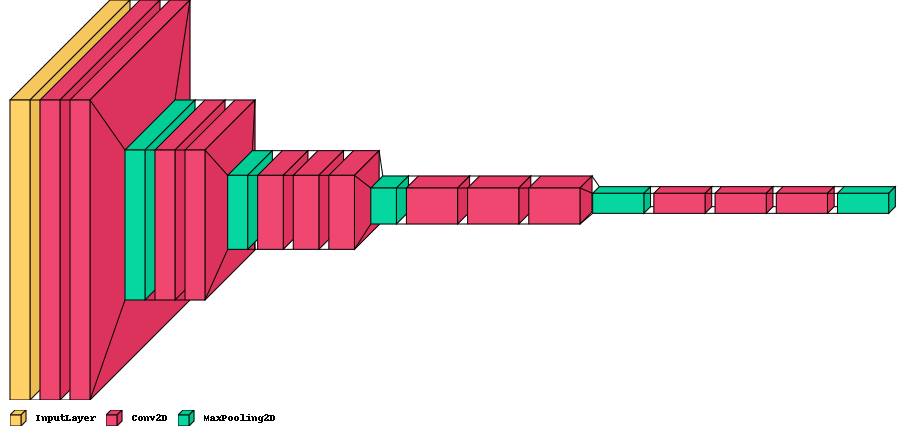

In [41]:
visualkeras.layered_view(vgg16_base).show() # display vgg16 model architecture
visualkeras.layered_view(vgg16_base, legend=True,scale_xy=2)

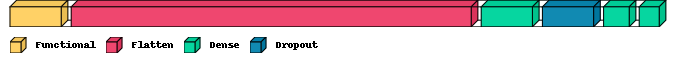

In [60]:
visualkeras.layered_view(model_t).show() # display vgg16 model architecture
visualkeras.layered_view(model_t, legend=True,scale_xy=2)

### Training Transfer Model

In [64]:
#training
history3 = model_t.fit(train_generator,validation_data=validation_generator, epochs=10)

Epoch 1/10
12/12 [==============================] - 42s 4s/step - loss: 1.1620 - accuracy: 0.5222 - val_loss: 0.7081 - val_accuracy: 0.7087
Epoch 2/10
12/12 [==============================] - 48s 4s/step - loss: 0.5688 - accuracy: 0.7722 - val_loss: 0.7172 - val_accuracy: 0.7008
Epoch 3/10
12/12 [==============================] - 51s 4s/step - loss: 0.4407 - accuracy: 0.8444 - val_loss: 0.3446 - val_accuracy: 0.8688
Epoch 4/10
12/12 [==============================] - 50s 4s/step - loss: 0.2705 - accuracy: 0.9083 - val_loss: 0.5252 - val_accuracy: 0.7795
Epoch 5/10
12/12 [==============================] - 51s 4s/step - loss: 0.2587 - accuracy: 0.8972 - val_loss: 0.4459 - val_accuracy: 0.8241
Epoch 6/10
12/12 [==============================] - 51s 4s/step - loss: 0.2241 - accuracy: 0.9028 - val_loss: 0.5746 - val_accuracy: 0.8084
Epoch 7/10
12/12 [==============================] - 49s 4s/step - loss: 0.2826 - accuracy: 0.9028 - val_loss: 0.3773 - val_accuracy: 0.8530
Epoch 8/10
12/12 [==

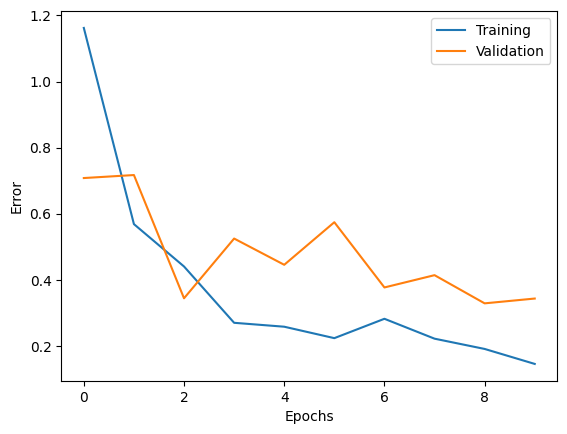

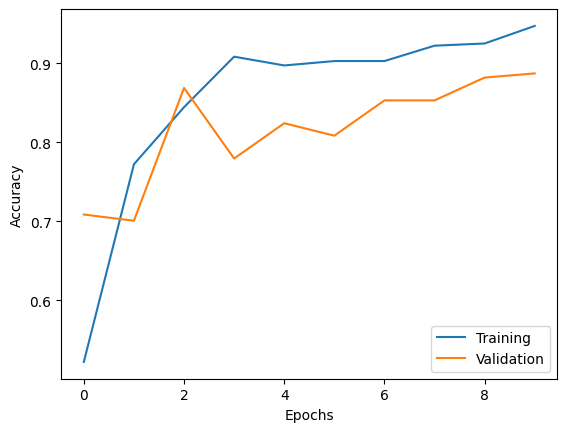

In [65]:
plot_curves(history3.history)

In [66]:
scores_tr = model_t.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model_t.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model_t.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

12/12 [==============================] - 21s 2s/step - loss: 0.0645 - accuracy: 0.9778
Train loss    : 0.064534492790699
Train accuracy: 0.9777777791023254
12/12 [==============================] - 26s 2s/step - loss: 0.3438 - accuracy: 0.8871
Val loss    : 0.343813955783844
Val accuracy: 0.887139081954956
13/13 [==============================] - 26s 2s/step - loss: 0.4567 - accuracy: 0.8553
Test loss    : 0.4567217230796814
Test accuracy: 0.8552971482276917


## 09 - Final Scores (Test)

Finally, it is time to compare the three models with the test dataset to see how well our model generalizes.



In [67]:
#model1
scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

#model2
scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

#model with transfer learning
scores_tr = model_t.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])



13/13 [==============================] - 3s 189ms/step - loss: 0.5876 - accuracy: 0.8527
Test loss    : 0.5875586271286011
Test accuracy: 0.8527131676673889
13/13 [==============================] - 4s 268ms/step - loss: 0.6389 - accuracy: 0.8088
Test loss    : 0.6389278173446655
Test accuracy: 0.8087855577468872
13/13 [==============================] - 27s 2s/step - loss: 0.4567 - accuracy: 0.8553
Test loss    : 0.4567217230796814
Test accuracy: 0.8552971482276917


## 10 - Predictions

In [68]:
#print classes indices
indices = train_generator.class_indices
print(indices)

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}


### Good predictions

1/1 [==============================] - 0s 101ms/step
Real: rain ,Predicted: shine


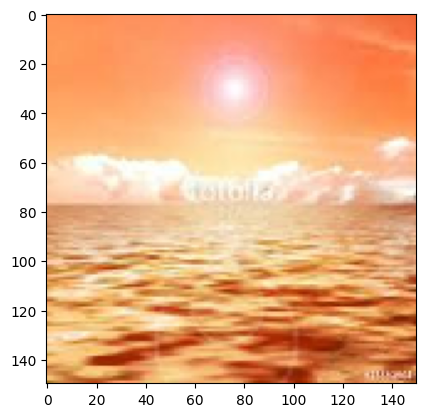

In [73]:
#prediction for rain samples
path = 'dataset/test/shine/shine_179.jpeg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: rain', ',Predicted:',list(indices.keys())[max_index])

Real: fogsmog ,Predicted: fogsmog


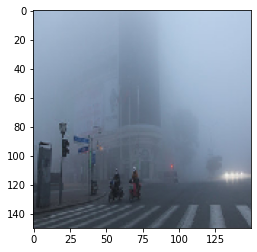

In [144]:
#prediction for fogsmog samples
path = 'dataset/test/fogsmog/fogsmog123.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: fogsmog', ',Predicted:',list(indices.keys())[max_index])

Real: snow ,Predicted: snow


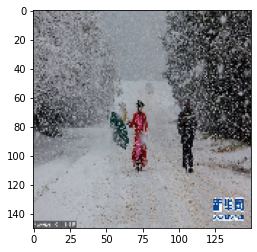

In [148]:
#prediction for snow samples
path = 'dataset/test/snow/snow12.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: snow', ',Predicted:',list(indices.keys())[max_index])

Real: sunrise ,Predicted: sunrise


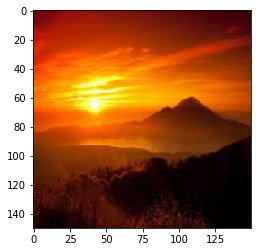

In [154]:
#prediction for sunrise samples
path = 'dataset/test/sunrise/sunrise133.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: sunrise', ',Predicted:',list(indices.keys())[max_index])

### Bad predictions

Real: sunrise ,Predicted: shine


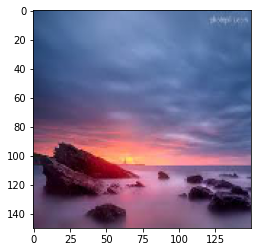

In [160]:
#prediction for sunrise samples
path = 'dataset/test/sunrise/sunrise106.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: sunrise', ',Predicted:',list(indices.keys())[max_index])

Real: rain ,Predicted: snow


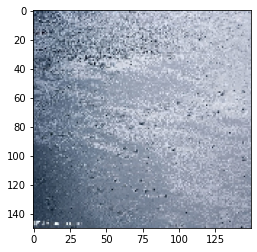

In [168]:
#prediction for rain samples
path = 'dataset/test/rain/rain120.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: rain', ',Predicted:',list(indices.keys())[max_index])

Real: fogsmog , Predicted: snow


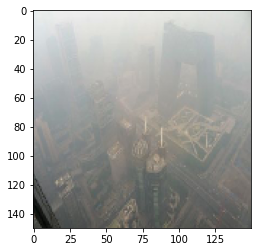

In [176]:
#prediction for fogsmog samples
path = 'dataset/test/fogsmog/fogsmog116.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: fogsmog', ', Predicted:',list(indices.keys())[max_index])

Real: shine , Predicted: snow


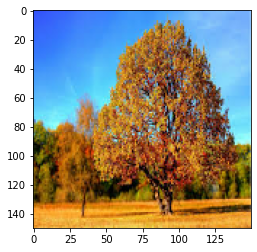

In [200]:
#prediction for shine samples
path = 'dataset/test/shine/shine12.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: shine', ', Predicted:',list(indices.keys())[max_index])

## 11 - Conclusions

Two models have been implemented from scratch to find out their learning behavior with few samples in the dataset. Then a model has been implemented using transfer learning, more specifically using the VGG16 model where we get better perfomance on a pre-trained model.

From the results obtained these models can learn features of weather phenomena well, specially the one with transfer learning which is effective for weather classification. However, this models confuses some categories of weather phenomena, which may be due to the similarity and complexity of the images.

Overall, the classification accuracy of transfer model is as high as 90% for validation and 87% for testing. Therefore, the proposed model can be widely applied to the daily observation of weather phenomenon images and also can provide weather guidance for environmental monitoring, agriculture, and transportation, especially belonging to weather change and forecasting.